# 3.2 傾向スコアを利用した効果の推定

In [11]:
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rdata
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.simplefilter("ignore")

## バイアスのあるデータの準備

In [2]:
data_biased = pd.read_csv("data_biased_cibook.csv")
data_biased.shape

(31961, 13)

In [3]:
data_biased.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
0,3,1) $0 - $100,58.13,1,0,Urban,1,Web,No E-Mail,1,0,0.0,0
1,9,1) $0 - $100,29.99,0,1,Surburban,1,Phone,No E-Mail,0,0,0.0,0
2,2,1) $0 - $100,29.99,0,1,Urban,1,Phone,No E-Mail,0,0,0.0,0


## 傾向スコアの推定

In [14]:
# trainとtestを分割
data_biased_train, data_biased_test = train_test_split(data_biased, test_size=0.2, random_state=71, shuffle=True, stratify=data_biased.conversion)
print(f"{data_biased_train.shape=}, {data_biased_test.shape=}")

data_biased_train.shape=(25568, 13), data_biased_test.shape=(6393, 13)


### ロジスティック回帰

In [15]:
ps_model_lr = smf.glm(
    formula='treatment ~ recency + history + channel',
    data=data_biased_train,
    family=sm.families.Binomial()  # 誤差構造 (二項分布)
).fit()

In [23]:
test_pred_lr = ps_model_lr.predict(data_biased_test).values
print(f"{test_pred_lr.shape=}")

test_pred_lr.shape=(6393,)


### LightGBM

In [31]:
import lightgbm as lgb

In [26]:
data_biased_tr, data_biased_val = train_test_split(data_biased_train, test_size=0.2, random_state=71, shuffle=True, stratify=data_biased_train.conversion)
data_biased_X_tr = data_biased_tr[["recency", "history", "channel"]]
data_biased_X_val = data_biased_val[["recency", "history", "channel"]]
data_biased_X_test = data_biased_test[["recency", "history", "channel"]]

print(f"{data_biased_X_tr.shape=}, {data_biased_X_val.shape=}, {data_biased_X_test.shape=}")

data_biased_X_tr.shape=(20454, 3), data_biased_X_val.shape=(5114, 3), data_biased_X_test.shape=(6393, 3)


In [28]:
data_biased_y_tr = data_biased_tr["treatment"]
data_biased_y_val = data_biased_val["treatment"]
data_biased_y_test = data_biased_test["treatment"]

print(f"{data_biased_y_tr.shape=}, {data_biased_y_val.shape=}, {data_biased_y_test.shape=}")

data_biased_y_tr.shape=(20454,), data_biased_y_val.shape=(5114,), data_biased_y_test.shape=(6393,)


In [37]:
data_biased_X_tr["channel"] = data_biased_X_tr["channel"].astype("category")
data_biased_X_val["channel"] = data_biased_X_val["channel"].astype("category")
data_biased_X_test["channel"] = data_biased_X_test["channel"].astype("category")

In [39]:
lgb_train = lgb.Dataset(data_biased_X_tr, data_biased_y_tr)
lgb_eval = lgb.Dataset(data_biased_X_val, data_biased_y_val, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "learning_rate": 0.05,
    "nthread": -1,
    "seed": 42
}

model = lgb.train(
        params, lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        verbose_eval=50,
        num_boost_round=50000,
        early_stopping_rounds=50,
    )

[LightGBM] [Info] Number of positive: 9857, number of negative: 10597
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 20454, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481911 -> initscore=-0.072389
[LightGBM] [Info] Start training from score -0.072389
Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.633291	valid_1's binary_logloss: 0.634372
[100]	training's binary_logloss: 0.626705	valid_1's binary_logloss: 0.636104
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.632674	valid_1's binary_logloss: 0.634141


In [41]:
test_pred_lgbm = model.predict(data_biased_X_test, num_iteration=model.best_iteration)
print(f"{test_pred_lgbm.shape=}")

test_pred_lgbm.shape=(6393,)


## 傾向スコアの分布

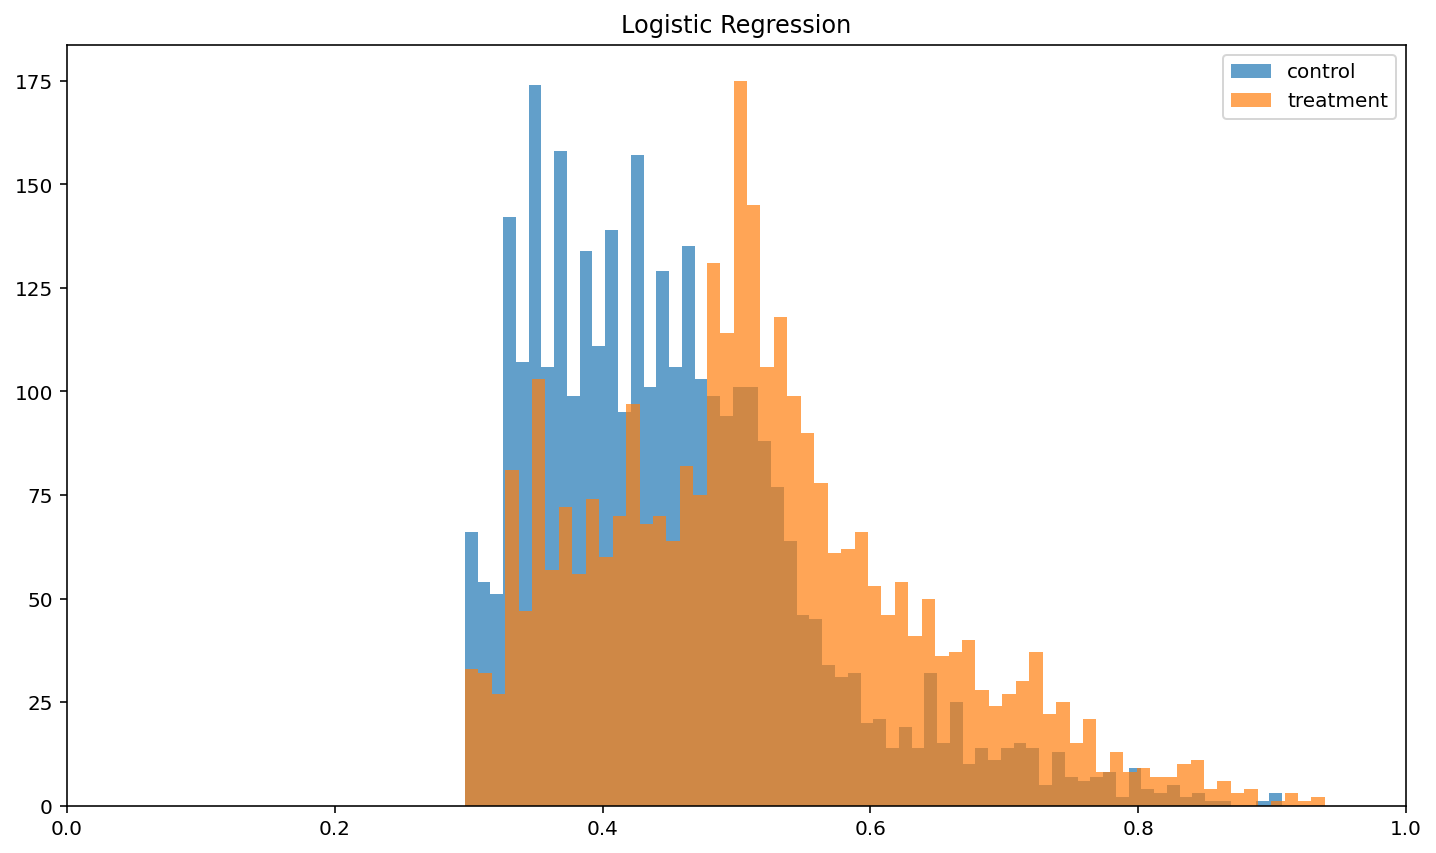

In [57]:
# Logistic Regression
plt.figure(figsize=(12, 7))
plt.hist(test_pred_lr[data_biased_y_test == 0], bins=64, alpha=0.7, color="tab:blue", label="control")
plt.hist(test_pred_lr[data_biased_y_test == 1], bins=64, alpha=0.7, color="tab:orange", label="treatment")
plt.legend()
plt.xlim([0.0, 1.0])
plt.title("Logistic Regression")
plt.show()

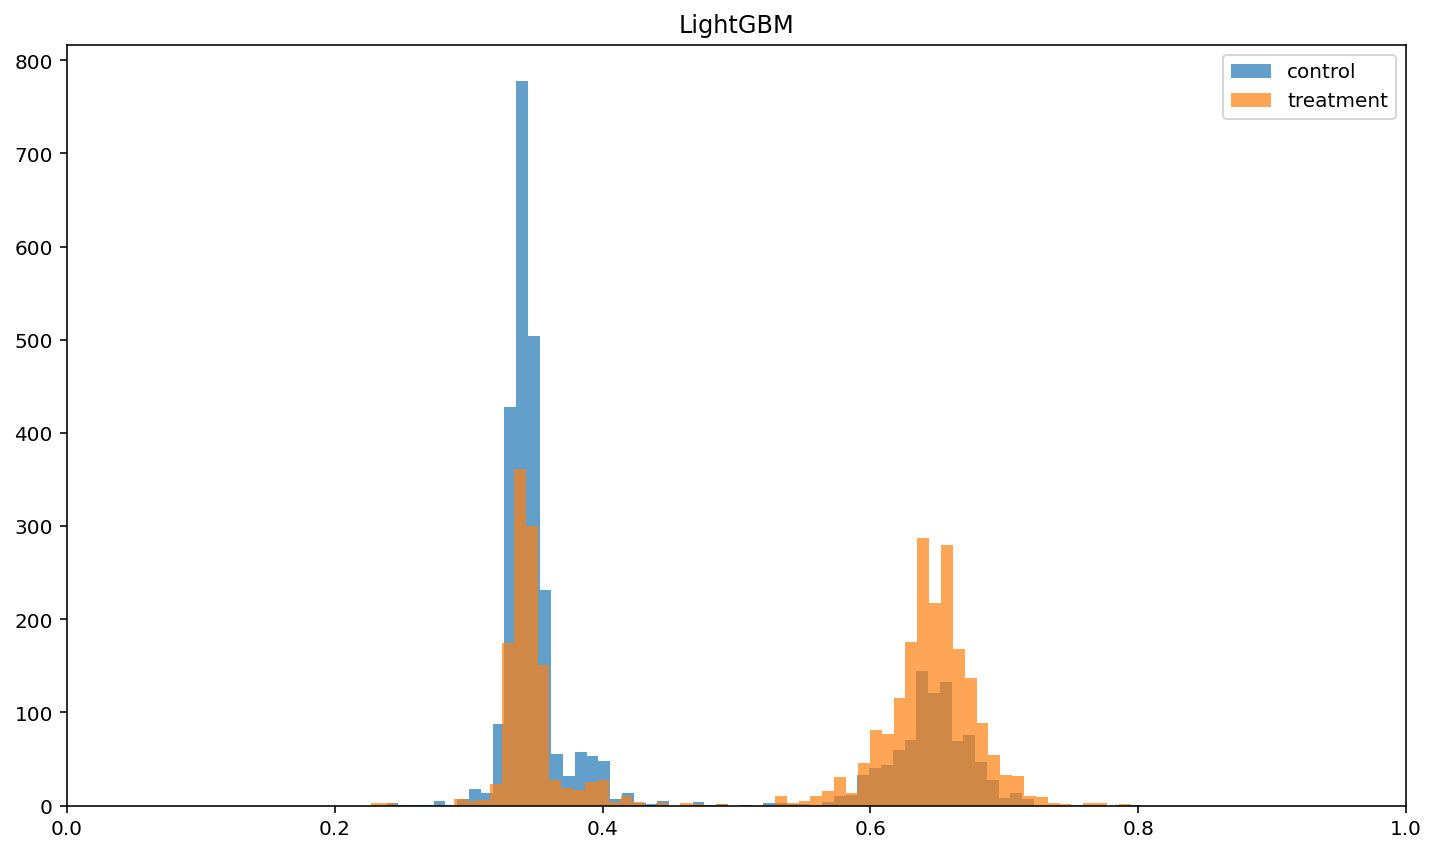

In [56]:
# Light GBM
plt.figure(figsize=(12, 7))
plt.hist(test_pred_lgbm[data_biased_y_test == 0], bins=64, alpha=0.7, color="tab:blue", label="control")
plt.hist(test_pred_lgbm[data_biased_y_test == 1], bins=64, alpha=0.7, color="tab:orange", label="treatment")
plt.legend()
plt.xlim([0.0, 1.0])
plt.title("LightGBM")
plt.show()

## 傾向スコアマッチング

In [59]:
import pandas as pd

class PropensityScoreMatching:
    def __init__(self, treatment: pd.DataFrame, control: pd.DataFrame, pscore_col: str = "pscore") -> None:
        self.treatment = treatment
        self.control = control
        self.pscore_col = pscore_col
        self.match_idx = {}

    def match(self) -> None:
        threshold = pd.concat([self.treatment, self.control])[self.pscore_col].std() * 0.2  # see: https://www.slideshare.net/okumurayasuyuki/ss-43780294
        match_pair_df = self.control.copy(deep=True)
        for i in range(self.treatment.shape[0]):
            matching_target = self.treatment.loc[i, self.pscore_col]
            matched_pair = ((match_pair_df[self.pscore_col] - matching_target)**2).loc[lambda x: x < threshold]
            if matched_pair.shape[0] != 0:  # マッチング対象が存在する場合
                matched_pair = matched_pair.idxmin()
                self.match_idx[i] = matched_pair

                if i % 5000 == 1:
                    print('Matching : [{}]. Propensity Score: {} Matched : [{}]. Propensity Score: {}'.format(
                        i, matching_target, matched_pair, match_pair_df.loc[matched_pair, self.pscore_col]
                    ))

                match_pair_df = match_pair_df.drop(matched_pair)
        print("Matched Ratio: {}".format(len(self.match_idx.keys())/self.treatment.shape[0]))

    def create_matched_df(self, target_col) -> pd.DataFrame:
        if len(self.match_idx.keys()) == 0:
            raise AttributeError("マッチングが行われていません。match()を呼び出した後に使ってください。")

        columns = ['idx', 'pscore', target_col, 'matched_idx', 'matched_pscore', 'matched_{}'.format(target_col)]
        idx, pscore, target, matched_idx, matched_pscore, matched_target = [], [], [], [], [], []
        for i, v in self.match_idx.items():
            idx += [i]
            pscore += [self.treatment.loc[i, self.pscore_col]]
            target += [self.treatment.loc[i, target_col]]
            matched_idx += [v]
            matched_pscore += [self.control.loc[v, self.pscore_col]]
            matched_target += [self.control.loc[v, target_col]]

        matched_df = pd.DataFrame(data = {col: val for col, val in zip(columns, [idx, pscore, target, matched_idx, matched_pscore, matched_target])})
        matched_df['diff'] = matched_df[target_col] - matched_df['matched_{}'.format(target_col)]
        return matched_df

In [58]:
data_biased_test["pscore_lr"] = test_pred_lr
data_biased_test["pscore_lgbm"] = test_pred_lgbm

data_biased_treatment = data_biased_test[data_biased_test['treatment'] == 1].reset_index(drop=True)
data_biased_control = data_biased_test[data_biased_test['treatment'] == 0].reset_index(drop=True)
print(f"{data_biased_treatment.shape=}, {data_biased_control.shape=}")


data_biased_treatment.shape=(3096, 15), data_biased_control.shape=(3297, 15)


In [61]:
# Logistic Regression
p_score_match_lr = PropensityScoreMatching(data_biased_treatment, data_biased_control, pscore_col="pscore_lr")
p_score_match_lr.match()

Matching : [1]. Propensity Score: 0.5328274263591385 Matched : [3095]. Propensity Score: 0.5328242150721398
Matched Ratio: 0.8885658914728682


In [63]:
matched_treatment_lr = data_biased_treatment.iloc[list(p_score_match_lr.create_matched_df('spend')['idx'].values)]
matched_control_lr = data_biased_control.iloc[list(p_score_match_lr.create_matched_df('spend')['matched_idx'].values)]
matched_data_lr = pd.concat([matched_treatment_lr, matched_control_lr])
print(f"{matched_data_lr.shape=}")
display(matched_data_lr.head())

matched_data_lr.shape=(5502, 15)


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,pscore_lr,pscore_lgbm
0,1,2) $100 - $200,198.78,0,1,Surburban,0,Web,Mens E-Mail,0,0,0.0,1,0.554365,0.677824
1,1,2) $100 - $200,123.71,0,1,Urban,0,Web,Mens E-Mail,0,0,0.0,1,0.532827,0.649793
2,2,2) $100 - $200,174.00,1,0,Surburban,1,Phone,Mens E-Mail,1,0,0.0,1,0.528890,0.668712
3,1,"6) $750 - $1,000",831.55,0,1,Surburban,1,Web,Mens E-Mail,0,0,0.0,1,0.721150,0.670185
4,1,1) $0 - $100,29.99,0,1,Surburban,0,Web,Mens E-Mail,1,0,0.0,1,0.505776,0.656894


In [65]:
# LightGBM
p_score_match_lgbm = PropensityScoreMatching(data_biased_treatment, data_biased_control, pscore_col="pscore_lgbm")
p_score_match_lgbm.match()

Matching : [1]. Propensity Score: 0.649793393068791 Matched : [315]. Propensity Score: 0.649793393068791
Matched Ratio: 0.6957364341085271


In [66]:
matched_treatment_lgbm = data_biased_treatment.iloc[list(p_score_match_lgbm.create_matched_df('spend')['idx'].values)]
matched_control_lgbm = data_biased_control.iloc[list(p_score_match_lgbm.create_matched_df('spend')['matched_idx'].values)]
matched_data_lgbm = pd.concat([matched_treatment_lgbm, matched_control_lgbm])
print(f"{matched_data_lgbm.shape=}")
display(matched_data_lgbm.head())

matched_data_lgbm.shape=(4308, 15)


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,pscore_lr,pscore_lgbm
0,1,2) $100 - $200,198.78,0,1,Surburban,0,Web,Mens E-Mail,0,0,0.0,1,0.554365,0.677824
1,1,2) $100 - $200,123.71,0,1,Urban,0,Web,Mens E-Mail,0,0,0.0,1,0.532827,0.649793
2,2,2) $100 - $200,174.00,1,0,Surburban,1,Phone,Mens E-Mail,1,0,0.0,1,0.528890,0.668712
3,1,"6) $750 - $1,000",831.55,0,1,Surburban,1,Web,Mens E-Mail,0,0,0.0,1,0.721150,0.670185
4,1,1) $0 - $100,29.99,0,1,Surburban,0,Web,Mens E-Mail,1,0,0.0,1,0.505776,0.656894


In [64]:
reg_lr = smf.ols(
    'spend ~ treatment',
    data=matched_data_lr
).fit()

reg_lr.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5588,0.263,2.128,0.033,0.044,1.074
treatment,0.6059,0.371,1.632,0.103,-0.122,1.334


In [67]:
reg_lgbm = smf.ols(
    'spend ~ treatment',
    data=matched_data_lgbm
).fit()

reg_lgbm.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6173,0.288,2.144,0.032,0.053,1.182
treatment,0.4601,0.407,1.130,0.259,-0.338,1.258
